In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display
from tensorflow.examples.tutorials.mnist import input_data


tfd = tf.contrib.distributions

plt.style.use('default')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [32]:
# Model: Encoder, prior and decoder
def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)

def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)

def make_decoder(code, data_shape):
    x = code
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    loc = tf.layers.dense(x, np.prod(data_shape), tf.nn.sigmoid)
    scale = tf.layers.dense(x, np.prod(data_shape), tf.nn.softplus)
    loc = tf.reshape(loc, [-1] + data_shape)
    scale = tf.reshape(scale, [-1] + data_shape)
    return tfd.Independent(tfd.MultivariateNormalDiag(loc, scale), 2)

def plot_online(epoch, codes, labels, samples, size=1):
    fig, ax = plt.subplots(ncols=1 + len(samples), figsize=((1 + len(samples)) * size, size))
    no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
    ax[0].set_ylabel('Epoch {}'.format(epoch))
    ax[0].scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax[0].set_aspect('equal')
    ax[0].set_xlim(codes.min() - .1, codes.max() + .1)
    ax[0].set_ylim(codes.min() - .1, codes.max() + .1)
    ax[0].tick_params(axis='both', which='both', **no_ticks)
    for index, sample in enumerate(samples):
        ax[1 + index].imshow(sample, cmap='gray')
        ax[1 + index].tick_params(axis='both', which='both', **no_ticks)
    display.display(fig)
    plt.close()

In [33]:
# Optimisation
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

data = tf.placeholder(tf.float32, [None, 28, 28])

# Define the model.
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 0 elbo -6223174.5


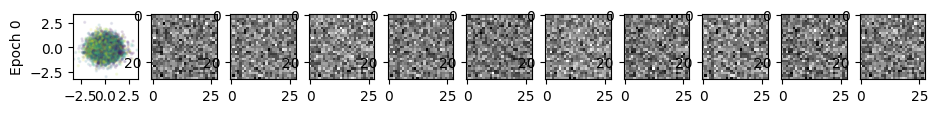

Epoch 1 elbo -113427430000.0


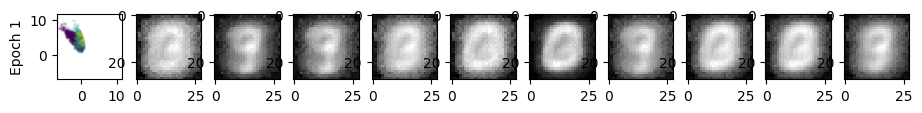

Epoch 2 elbo 5853497.5


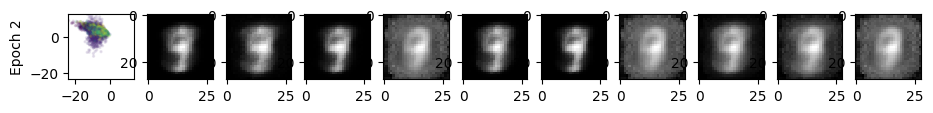

Epoch 3 elbo nan


ValueError: Axis limits cannot be NaN or Inf

<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/ludwig/documents/informatics/master/02_Master/01_MP/02_EX/masters-practicum-mlcms/exercise4/.venv/lib/python3.6/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


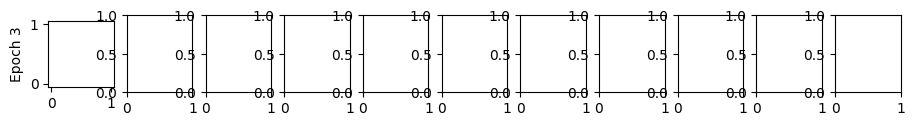

In [34]:
samples = make_decoder(prior.sample(10,1), [28, 28]).mean()

mnist = input_data.read_data_sets('MNIST_data/')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(200):
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        plot_online(epoch, test_codes, mnist.test.labels, test_samples)
        for _ in range(600):
            feed = {data: mnist.train.next_batch(128)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)

In [24]:
mnist = input_data.read_data_sets('MNIST_data/')
#print(mnist.train.next_batch(1)[0].reshape([-1,28,28]))

mnist = tf.keras.datasets.mnist.load_data()
train = mnist[0]
test = mnist[1]

X_train = train[0]/255
y_train = train[1]

X_test = test[0]/255
y_test = test[1]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [25]:
samples = make_decoder(prior.sample(10,1), [28,28]).mean()

mnist = input_data.read_data_sets('MNIST_data/')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(200):
        feed = {data: X_test}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        #plot_online(epoch, test_codes, mnist.test.labels, test_samples)
        for _ in range(600):
            feed = {data: X_train[:128]}
            sess.run(optimize, feed)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 0 elbo -1.2102292e+16
Epoch 1 elbo nan
Epoch 2 elbo nan
Epoch 3 elbo nan


KeyboardInterrupt: 